# AI 전문가 교육과정 실습 1 - part 1

***
### NLP응용: 토픽 추출
Applied Natrual Language Processing: Topic Modeling

강사: 차미영 교수 (카이스트 전산학부)    
조교: 신민기, 정현규 (카이스트 전산학부)

실습 담당: 신민기 (mingi.shin@kaist.ac.kr)

# Gensim LDA, Visualization

In [1]:
!pip install pyLDAvis==3.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135598 sha256=600f8b1ac1b4a154784740b687d9d23020459f0f9f1941b127c559e25c21dd43
  Stored in directory: /root/.cache/pip/wheels/20/a4/75/e8ae5c16ebb85de43dfa0f238db03b19592fa4b3063882bb14
Successfully built pyLDAvis


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim: Topic Modeling Library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Scikit-learn: Machine learning library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK: NLP library
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Topic modeling with Gensim LDA

Gensim: Gensim is a free open-source Python library for representing documents as semantic vectors, as efficiently (computer-wise) and painlessly (human-wise) as possible. Gensim is designed to process raw, unstructured digital texts (“plain text”) using unsupervised machine learning algorithms.

More detailed information: https://radimrehurek.com/gensim/index.html

### Load data

20newsgroups data: This dataset is a collection newsgroup documents. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

20newsgroups 데이터셋은 각각 중심 주제를 가진 메일링 리스트에서 교환된 문서의 집합입니다.

More detailed information: https://www.kaggle.com/crawford/20-newsgroups

In [4]:
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'qutes'))

In [5]:
news_df = pd.DataFrame({'News': dataset.data,
                       'Target': dataset.target})
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x])
news_df

,News,Target,Target_name
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware
2,Can somebody please help me with information a...,12,sci.electronics
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16,talk.politics.guns
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7,rec.autos
...,...,...,...
11309,In article <1qvs9t$q3f@usenet.INS.CWRU.Edu> Ch...,4,comp.sys.mac.hardware
11310,"Hi,\nI've got a Multi I/O card (IDE controller...",3,comp.sys.ibm.pc.hardware
11311,\n As a person who has rarely even SEEN Do...,10,rec.sport.hockey
11312,>> So they should sue the newspaper I got it f...,1,comp.graphics


### Preprocessing

In [6]:
data = news_df.News.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['the', 'real', 'question', 'here', 'in', 'my', 'opinion', 'is', 'what', 'motorola', 'processors', 'running', 'system', 'on', 'mac', 'are', 'comparable', 'to', 'what', 'intel', 'processors', 'running', 'windows', 'on', 'pc', 'recall', 'there', 'being', 'conversation', 'here', 'that', 'running', 'windows', 'benchmarks', 'at', 'about', 'the', 'same', 'speed', 'as', 'mhz', 'in', 'system', 'dont', 'know', 'if', 'that', 'is', 'true', 'but', 'would', 'love', 'to', 'hear', 'if', 'anyone', 'has', 'any', 'technical', 'data', 'on', 'this', 'david']]


### Adding bigrams + trigrams

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) #

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'real', 'question', 'here', 'in', 'my', 'opinion', 'is', 'what', 'motorola', 'processors', 'running', 'system', 'on', 'mac', 'are', 'comparable', 'to', 'what', 'intel', 'processors', 'running', 'windows', 'on', 'pc', 'recall', 'there', 'being', 'conversation', 'here', 'that', 'running', 'windows', 'benchmarks', 'at', 'about', 'the', 'same', 'speed', 'as', 'mhz', 'in', 'system', 'dont', 'know', 'if', 'that', 'is', 'true', 'but', 'would', 'love', 'to', 'hear', 'if', 'anyone', 'has', 'any', 'technical', 'data', 'on', 'this', 'david']


In [9]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['real', 'question', 'opinion', 'motorola', 'processor', 'run', 'system', 'comparable', 'processor', 'run', 'window', 'pc', 'recall', 'conversation', 'run', 'window', 'benchmark', 'speed', 'mhz', 'system', 'know', 'true', 'love', 'hear', 'technical', 'datum']]


### Create the dictionary and the corpus

In [11]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 2), (18, 1), (19, 1), (20, 2)]]


In [12]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('benchmark', 1),
  ('comparable', 1),
  ('conversation', 1),
  ('datum', 1),
  ('hear', 1),
  ('know', 1),
  ('love', 1),
  ('mhz', 1),
  ('motorola', 1),
  ('opinion', 1),
  ('pc', 1),
  ('processor', 2),
  ('question', 1),
  ('real', 1),
  ('recall', 1),
  ('run', 3),
  ('speed', 1),
  ('system', 2),
  ('technical', 1),
  ('true', 1),
  ('window', 2)]]

### Build LDA model

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"use" + 0.018*"system" + 0.017*"window" + 0.017*"program" + '
  '0.014*"also" + 0.013*"set" + 0.012*"do" + 0.012*"mail" + 0.012*"type" + '
  '0.012*"find"'),
 (1,
  '0.052*"drive" + 0.032*"bit" + 0.024*"card" + 0.021*"driver" + 0.017*"run" + '
  '0.017*"speed" + 0.017*"fast" + 0.016*"problem" + 0.016*"machine" + '
  '0.015*"disk"'),
 (2,
  '0.086*"mph" + 0.022*"accelerate" + 0.021*"compuserve" + 0.008*"ch" + '
  '0.007*"mp" + 0.007*"cad" + 0.001*"pl" + 0.000*"lane" + 0.000*"bj" + '
  '0.000*"rk"'),
 (3,
  '0.031*"people" + 0.025*"say" + 0.019*"believe" + 0.015*"true" + '
  '0.014*"mean" + 0.013*"argument" + 0.013*"claim" + 0.012*"question" + '
  '0.012*"law" + 0.011*"word"'),
 (4,
  '0.020*"public" + 0.018*"israeli" + 0.018*"report" + 0.018*"provide" + '
  '0.016*"research" + 0.015*"organization" + 0.014*"center" + '
  '0.013*"technology" + 0.013*"baseball" + 0.012*"lock"'),
 (5,
  '0.041*"return" + 0.026*"faith" + 0.025*"earth" + 0.024*"save" + '
  '0.022*"love" + 0.021*

### Evaluate the LDA model

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.421568461473882

Coherence Score:  0.46770273036592747


### Visualization

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.349028  0.109983       1        1  41.876161
3     -0.290221  0.202731       2        1  11.349683
0     -0.291743 -0.148517       3        1  11.104666
7      0.136324  0.007884       4        1   5.908364
13    -0.162872  0.182935       5        1   5.095186
1     -0.187551 -0.247457       6        1   5.071940
4     -0.127874 -0.108147       7        1   4.027964
19    -0.130925  0.051269       8        1   3.909518
18    -0.055921 -0.168643       9        1   2.670801
5     -0.077949  0.128342      10        1   2.490990
17    -0.032360 -0.176529      11        1   2.319374
10     0.054306  0.057652      12        1   1.210878
15     0.156700  0.008386      13        1   0.610171
9      0.159520  0.015112      14        1   0.516588
11     0.182952  0.016258      15        1   0.478778
14     0.187515  0.012928      16        1   0.401025
8      0.191133  0.009398      17        1   0.386604
12     0.198751  0.015077      18        1   0.316113
16     0.212914  0.014290      19        1   0.180924
2      0.226330  0.017049      20        1   0.074274, topic_info=          Term          Freq         Total Category  logprob  loglift
726         ax  38754.000000  38754.000000  Default  30.0000  30.0000
307      point   4398.000000   4398.000000  Default  29.0000  29.0000
175       game   2429.000000   2429.000000  Default  28.0000  28.0000
182     people   8577.000000   8577.000000  Default  27.0000  27.0000
544     church   3616.000000   3616.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
5051     turbo      0.016496      1.409578  Topic20 -10.8483   2.7572
4065  download      0.016495      1.409569  Topic20 -10.8483   2.7572
6326     ahead      0.016495      1.409597  Topic20 -10.8483   2.7572
3879     modem      0.016496      1.409618  Topic20 -10.8483   2.7572
7830       oil      0.016496      1.409639  Topic20 -10.8483   2.7572

[913 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1687     10  0.995473    absolute
1910     20  0.948667  accelerate
250       2  0.989962      accept
250       5  0.009544      accept
511       3  0.082398      access
...     ...       ...         ...
629       7  0.069121        year
629       8  0.170108        year
629      10  0.003515        year
629      12  0.050611        year
1559     14  0.996562   yesterday

[1464 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 1, 8, 14, 2, 5, 20, 19, 6, 18, 11, 16, 10, 12, 15, 9, 13, 17, 3])

### Choose the number of topics

In [17]:
from tqdm import tqdm

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model =  gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=35, step=6)

100%|██████████| 6/6 [05:20<00:00, 53.42s/it]


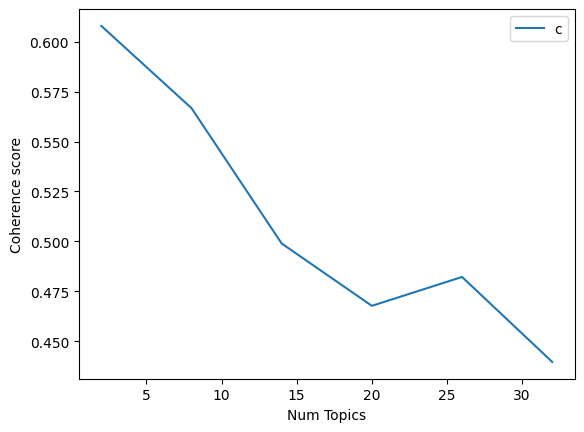

In [20]:
limit=35; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Finding the dominant topic in each sentence

In [21]:
optimal_model = model_list[1]

In [22]:
optimal_model.per_word_topics = False

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_dict = {'Dominant_Topic': [], 'Perc_Contribution': [], 'Topic_Keywords': []}

    # Get main topic in each document
    for i, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_dict['Dominant_Topic'].append(int(topic_num))
                sent_topics_dict['Perc_Contribution'].append(round(prop_topic, 4))
                sent_topics_dict['Topic_Keywords'].append(topic_keywords)
            else:
                break
    sent_topics_df = pd.DataFrame(sent_topics_dict)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

11314it [00:17, 645.81it/s]


In [24]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [25]:
df_dominant_topic.head(50)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.4987,"use, drive, file, bit, window, run, get, syste...",The real question here in my opinion is what M...
1,1,6,0.3474,"write, get, article, go, know, make, say, thin...",Please could someone in the US give me the cur...
2,2,6,0.6081,"write, get, article, go, know, make, say, thin...",Can somebody please help me with information a...
3,3,4,0.3924,"key, space, system, information, provide, publ...","In article (Pat Myrto) writes: >I am sick, dis..."
4,4,6,0.6389,"write, get, article, go, know, make, say, thin...",From article by (John R. Daker): > > Cup holde...
5,5,6,0.5699,"write, get, article, go, know, make, say, thin...",In article writes: (Jim Mann) writes: [deleted...
6,6,1,0.7592,"use, drive, file, bit, window, run, get, syste...","I have this used equipment for sale, everythin..."
7,7,6,0.4367,"write, get, article, go, know, make, say, thin...",I just recently bought a 4 MB ram card for my ...
8,8,6,0.3927,"write, get, article, go, know, make, say, thin...",In article (Gary V. Cavano) writes: >Im new to...
9,9,6,0.4231,"write, get, article, go, know, make, say, thin...","In writes: > I may be wrong, but wasnt Jeff Fe..."


+ 각각의 토픽을 어떻게 이름 붙일 수 있을지 생각해 보자.
+ Lemmatization에 다른 품사를 포함시키면 어떨까?
+ Stopwords를 제거하지 않으면 결과는 어떨까?
+ Topic 개수를 바꾸면 결과는 어떨까? 가장 적절한 topic 개수는 어떻게 정할까?